## Create CSV file
(For easy access of files)

We've 4 folders. 1.CT, 2.CT_dicom, 3.Mask, 4.Mask_dicom. CT_dicom contains files of a whole Lung CT. But CT contains of separate normalized image for each channel for every Lung CT image. Mask_dicom contains segmentation map.

We've used normalized 2D images found in the CT and Mask folders in this notebook.

In [6]:
path = "/home/ubuntu/dataset/emphysema/"

In [7]:
import os
import glob
import pandas as pd

In [8]:
nb_images = os.listdir(f'{path}CT')
print(f"No.of.images: {len(nb_images)}")

No.of.images: 956


In [9]:
nb_masks = os.listdir(f'{path}Mask')
print(f"No.of.Masks: {len(nb_masks)}")

No.of.Masks: 956


In [10]:
# For clarification
# To check whether CT and Mask files matches

CT = os.listdir(f'{path}CT/')
Mask = os.listdir(f'{path}Mask/')

set(CT) == set(Mask)

True

In [11]:
nb_images = glob.glob(f'{path}CT/*/*.dcm',recursive=True)
nb_masks = glob.glob(f"{path}Mask/*/*.npy",recursive=True)

In [12]:
dataset = pd.DataFrame({"CT_images":nb_images})

In [13]:
dataset.head()

,CT_images
0,/home/ubuntu/dataset/emphysema/CT/00309989/923...
1,/home/ubuntu/dataset/emphysema/CT/00309989/95A...
2,/home/ubuntu/dataset/emphysema/CT/00309989/93E...
3,/home/ubuntu/dataset/emphysema/CT/00309989/908...
4,/home/ubuntu/dataset/emphysema/CT/00309989/908...


In [14]:
dataset.iloc[0][0]

'/home/ubuntu/dataset/emphysema/CT/00309989/92366847.dcm'

In [15]:
nb_images[:5]

['/home/ubuntu/dataset/emphysema/CT/00309989/92366847.dcm',
 '/home/ubuntu/dataset/emphysema/CT/00309989/95A019C1.dcm',
 '/home/ubuntu/dataset/emphysema/CT/00309989/93EB4100.dcm',
 '/home/ubuntu/dataset/emphysema/CT/00309989/90818F84.dcm',
 '/home/ubuntu/dataset/emphysema/CT/00309989/90818F6B.dcm']

In [16]:
nb_masks[:5]

['/home/ubuntu/dataset/emphysema/Mask/00309989/38_mask.npy',
 '/home/ubuntu/dataset/emphysema/Mask/00309989/60_mask.npy',
 '/home/ubuntu/dataset/emphysema/Mask/00309989/44_mask.npy',
 '/home/ubuntu/dataset/emphysema/Mask/00309989/51_mask.npy',
 '/home/ubuntu/dataset/emphysema/Mask/00309989/11_mask.npy']

## obj file Parser

In [17]:
"""
This module implements a parser for Analyze object maps (.obj files).

Author: Petro Kostandy
"""
import struct
import numpy as np


class AnalyzeObject(object):
    """Data class storing header information about a particular object in the object map."""
    def __init__(self):
        self.name = ''  # null-terminated char32 string
        self.display_flag = 0  # int, 0 or 1
        self.copy_flag = 0  # uint8, 0 or 1
        self.mirror = 0  # uint8, 1-7
        self.status = 0  # uint8, unused
        self.n_used = 0  # uint8,
        self.shades = 0  # uint8

        self.s_red = 0  # int32
        self.s_green = 0  # int32
        self.s_blue = 0  # int32

        self.e_red = 0  # int32
        self.e_green = 0  # int32
        self.e_blue = 0  # int32

        self.x_rot = 0  # int32
        self.y_rot = 0  # int32
        self.z_rot = 0  # int32

        self.x_shift = 0  # int32
        self.y_shift = 0  # int32
        self.z_shift = 0  # int32

        self.x_center = 0  # int32
        self.y_center = 0  # int32
        self.z_center = 0  # int32

        self.i_xrot = 0  # int32
        self.i_yrot = 0  # int32
        self.i_zrot = 0  # int32

        self.i_xshift = 0  # int32
        self.i_yshift = 0  # int32
        self.i_zshift = 0  # int32

        self.min_x = 0  # int16
        self.min_y = 0  # int16
        self.min_z = 0  # int16

        self.max_x = 0  # int16
        self.max_y = 0  # int16
        self.max_z = 0  # int16

        self.opacity = 0.0  # float32
        self.opacity_thick = 0  # int32
        self.blendfactor = 0.0  # float32


class AnalyzeObjectMap(object):
    """Describes an object that can fully capture the contents of an Analayze object map. This
    class can be initalized with an optional ``file`` argument.

    Args:
        file (str): Analyze object map file path. Optional.

    The following attributes are initialized and populated once `from_file` is called:
        version_code (int): File format revision number
        version (int): .obj file version
        width (int): Width of map in pixels
        height (int): Height of map in pixels
        depth (int): Depth of map in pixels
        n_objects (int): Number of objects (up to 256)
        n_vols (int): Number of object volumes

        objects (list): List of objects included in the object map
        vols (list): List of volumes contained within the object map;
            where each map is a 3 dimensional array.

    Usage::
        # Create instance with file argument
        obj_map = AnalayzeObjectMap(file='path/to/file.obj')

        # Alternatively, initialize instance and then call from_file method
        obj_map = AnalyzeObjectMap()
        obj_map.from_file('path/to/file.obj')

        # Get numpy array representing the first volume
        obj_map.get_data(0)
    """
    def __init__(self, file=None):
        self.version_code = 0
        self.version = 0
        self.width = 0
        self.height = 0
        self.depth = 0
        self.n_objects = 0
        self.n_vols = 1

        self.objects = []
        self.vols = []

        if file:
            self.from_file(file)


    @staticmethod
    def _read_nts(bytecode):
        """Reads one byte at a time from file buffer until a null character is encountered."""
        return bytecode.split(b'\x00')[0].decode('utf-8')


    def from_file(self, filename, verbose=0):
        """Parses the .obj file that is passed preserving its header information and casting
        the object maps as numpy arrays.

        Args:
            filename (str): Full .obj file path
            verbose (int, optional): Defaults to 0. Controls output verbosity.
        """
        with open(filename, 'rb') as f:
            self.version_code = int.from_bytes(
                f.read(4), byteorder='big', signed=False)

            # Set header_ints and version based on version_code
            if self.version_code < 20050829:
                self.version = 6
                header_ints = 4
            else:
                self.version = 7
                header_ints = 5

            header = []

            for i in range(header_ints):
                header.append(
                    int.from_bytes(f.read(4), byteorder='big', signed=False))

            self.width, self.height, self.depth = header[0:3]
            self.n_objects = header[3]

            if self.version > 7:
                self.n_vols = header[4]

            # Read in each object's parameters sequentially from object map header
            # Numerics bytes are stored by Analyze in big-endian order
            count = -1
            self.dict_ = {}
            for i in range(self.n_objects):
                obj = AnalyzeObject()

                obj.name = self._read_nts(f.read(32))
                obj.display_flag = int.from_bytes(f.read(4), byteorder='big')
                obj.copy_flag = int.from_bytes(f.read(1), byteorder='big')
                obj.mirror = int.from_bytes(f.read(1), byteorder='big')
                obj.status = int.from_bytes(f.read(1), byteorder='big')
                obj.n_used = int.from_bytes(f.read(1), byteorder='big')
                obj.shades = int.from_bytes(f.read(4), byteorder='big')

                obj.s_red = int.from_bytes(f.read(4), byteorder='big')
                obj.s_green = int.from_bytes(f.read(4), byteorder='big')
                obj.s_blue = int.from_bytes(f.read(4), byteorder='big')

                obj.e_red = int.from_bytes(f.read(4), byteorder='big')
                obj.e_green = int.from_bytes(f.read(4), byteorder='big')
                obj.e_blue = int.from_bytes(f.read(4), byteorder='big')

                obj.x_rot = int.from_bytes(f.read(4), byteorder='big')
                obj.y_rot = int.from_bytes(f.read(4), byteorder='big')
                obj.z_rot = int.from_bytes(f.read(4), byteorder='big')

                obj.x_shift = int.from_bytes(f.read(4), byteorder='big')
                obj.y_shift = int.from_bytes(f.read(4), byteorder='big')
                obj.z_shift = int.from_bytes(f.read(4), byteorder='big')

                obj.x_center = int.from_bytes(f.read(4), byteorder='big')
                obj.y_center = int.from_bytes(f.read(4), byteorder='big')
                obj.z_center = int.from_bytes(f.read(4), byteorder='big')

                obj.i_xrot = int.from_bytes(f.read(4), byteorder='big')
                obj.i_yrot = int.from_bytes(f.read(4), byteorder='big')
                obj.i_zrot = int.from_bytes(f.read(4), byteorder='big')

                obj.i_xshift = int.from_bytes(f.read(4), byteorder='big')
                obj.i_yshift = int.from_bytes(f.read(4), byteorder='big')
                obj.i_zshift = int.from_bytes(f.read(4), byteorder='big')

                obj.min_x = int.from_bytes(f.read(2), byteorder='big')
                obj.min_y = int.from_bytes(f.read(2), byteorder='big')
                obj.min_z = int.from_bytes(f.read(2), byteorder='big')

                obj.max_x = int.from_bytes(f.read(2), byteorder='big')
                obj.max_y = int.from_bytes(f.read(2), byteorder='big')
                obj.max_z = int.from_bytes(f.read(2), byteorder='big')

                obj.opacity = struct.unpack('f', f.read(4))
                obj.opacity_thick = int.from_bytes(f.read(4), byteorder='big')
                obj.blendfactor = struct.unpack('f', f.read(4))
                count += 1
                if obj.name in self.dict_:
                    self.dict_[obj.name] = self.dict_[obj.name] + [count]
                else:
                    self.dict_[obj.name] = [count]
#                 print(obj.name, count)             
                self.objects.append(obj)

            # Read in the reminader of the file, which happens to be run-length encoded
            maps_rle = np.frombuffer(f.read(), dtype='uint8').reshape((-1, 2))
            i = 0

            # Iterate over each volume (relevant for 4-D data)
            for _ in range(self.n_vols):
                slice_num = 0
                temp_vol = np.zeros((self.height, self.width, self.depth))

                # Iterate over every slice separately
                while slice_num < self.depth:
                    pixel_num = 0
                    temp_slice = np.zeros((self.width * self.height))

                    while pixel_num < self.width * self.height:
                        mult, num = maps_rle[i, :]
                        temp_slice[pixel_num:pixel_num+mult] = np.repeat(num, mult)
                        pixel_num += mult
                        i += 1

                    temp_vol[:, :, slice_num] = temp_slice.reshape(self.height, self.width)
                    slice_num += 1
                self.vols.append(temp_vol.copy())

            if verbose > 0:
                print('Successfully imported {0}'.format(filename))
                print('Object map shape: {0}'.format(self.vols[0].shape))
                print('Number of objects (includes background): {0}'.format(self.n_objects))
                print('Number of volumes: {0}'.format(self.n_vols))


    def get_data(self, idx=0):
        """Returns a numpy array representing the object map."""
        return self.vols[idx], self.dict_

## Constructing Mask arrays

In [31]:
path = "/home/ubuntu/dataset/emphysema/Mask/"

In [32]:
file_names = os.listdir(path)

In [33]:
len(file_names)

956

In [34]:
file_names[0]

'00309989'

In [35]:
mask_objs = glob.glob(f'{path}*/*.obj',recursive=True)

In [36]:
len(mask_objs)

956

In [37]:
mask_objs[0]

'/home/ubuntu/dataset/emphysema/Mask/00309989/181644_Series_2_1_Emph.obj'

In [38]:
file_names_ = file_names
mask_objs_ = mask_objs

In [39]:
'''
for batch,mask_obj in enumerate(mask_objs_):
    obj_map = AnalyzeObjectMap(file=mask_obj)
    obj_map = obj_map.get_data(0)
    data,_ = obj_map
    x,y,z = data.shape
    data = data.reshape((z,x,y))
    
    for i in range(z):
        
        pt = data[i]
        np.save(f"{path}{file_names_[batch]}/{i}_mask.npy",pt)
    print(f'{batch} has completed')
'''

'\nfor batch,mask_obj in enumerate(mask_objs_):\n    obj_map = AnalyzeObjectMap(file=mask_obj)\n    obj_map = obj_map.get_data(0)\n    data,_ = obj_map\n    x,y,z = data.shape\n    data = data.reshape((z,x,y))\n    \n    for i in range(z):\n        \n        pt = data[i]\n        np.save(f"{path}{file_names_[batch]}/{i}_mask.npy",pt)\n    print(f\'{batch} has completed\')\n'

## Create DataFrame

In [40]:
import os
import glob
import pydicom as dcm
import pandas as pd

In [41]:
path = "/home/ubuntu/dataset/emphysema/"

In [42]:
whole_files = os.listdir(f"{path}Mask/")
ct_files = os.listdir(f"{path}CT_dicom/")

In [44]:
mask_names = []
for file in whole_files:
    ct = os.listdir(f"{path}CT_dicom/{file}")[0]
    img = dcm.dcmread(f"{path}CT_dicom/{file}/{ct}").pixel_array
    z,_,_ = img.shape
    
    for i in range(z):
        mask = f"{path}Mask/{file}/{i}_mask.npy"
        mask_names.append(mask)

KeyboardInterrupt: 

In [ ]:
len(mask_names)

In [ ]:
nb_images = glob.glob(f'{path}CT/*/*.dcm',recursive=True)
len(nb_images)

In [ ]:
dataset = pd.DataFrame({"CT_images":nb_images,"Mask_images":mask_names})

In [ ]:
dataset.head()

In [ ]:
dataset.to_csv(f'{path}2D_dataset.csv',index=False)

## Visualization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL.Image as Image
import pydicom as dcm

In [2]:
path = "/home/ubuntu/dataset/emphysema/"

In [3]:
def show_ct(file_path):
    file = dcm.dcmread(file_path)
    file = file.pixel_array
    plt.figure(figsize=(8,12))
    plt.axis('off')
    plt.imshow(file,cmap='gray')

In [4]:
def show_mask(file_path):
    file = np.load(file_path,allow_pickle=True)
    plt.figure(figsize=(8,12))
    plt.axis('off')
    plt.imshow(file,cmap='gray')

In [5]:
dataset_df = pd.read_csv(f'{path}2D_dataset.csv')

In [6]:
dataset_df.head()

,CT_images,Mask_images
0,/home/ubuntu/dataset/emphysema/CT/00309989/923...,/home/ubuntu/dataset/emphysema/Mask/00309989/0...
1,/home/ubuntu/dataset/emphysema/CT/00309989/95A...,/home/ubuntu/dataset/emphysema/Mask/00309989/1...
2,/home/ubuntu/dataset/emphysema/CT/00309989/93E...,/home/ubuntu/dataset/emphysema/Mask/00309989/2...
3,/home/ubuntu/dataset/emphysema/CT/00309989/908...,/home/ubuntu/dataset/emphysema/Mask/00309989/3...
4,/home/ubuntu/dataset/emphysema/CT/00309989/908...,/home/ubuntu/dataset/emphysema/Mask/00309989/4...


'/home/ubuntu/dataset/emphysema/CT/00309989/93EB4100.dcm'

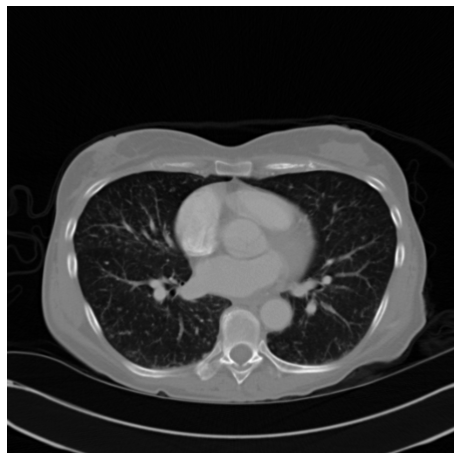

In [7]:
show_ct(f'{dataset_df.iloc[2,0]}')
dataset_df.iloc[2,0]

'/home/ubuntu/dataset/emphysema/Mask/00312252/64_mask.npy'

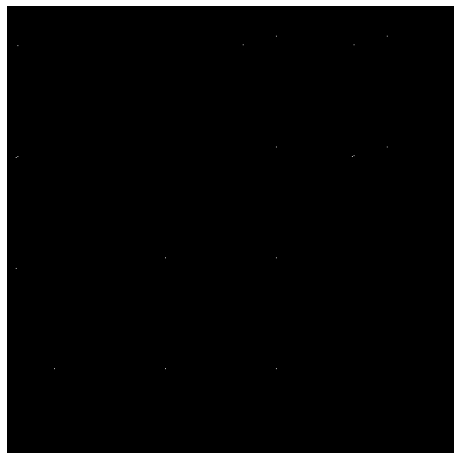

In [10]:
show_mask(f'{dataset_df.iloc[125,1]}')
dataset_df.iloc[125,1]

---